## IF + VC + SMOTE

In [1]:
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from numpy import loadtxt
from numpy import sort
from numpy import mean
from sklearn.metrics import cohen_kappa_score
#from autoimpute.imputations import MultipleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


from sklearn.impute import SimpleImputer 
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

### Reading the data

In [2]:
df = pd.read_excel("Updated_UKBioBank.xlsx")

In [3]:
### removing the redundant column as advised by collaborators
df = df.iloc[:, df.columns != 'QTrest']

### Imputing values using SimpleImputer

In [4]:
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
Imputed_df = imp.fit_transform(df)
# # 

In [5]:
df = pd.DataFrame(Imputed_df)
df = df.rename(columns={0: "eid", 1: "sex", 2:'RRrest', 3:'Tperest', 4:'QTc', 5:'QRS_rest', 6:'Age',
                       7:'BMI', 8:'Diab', 9:'smoke', 10:'DBP', 11:'SBP', 12:'chol', 13:'PR', 14:'AF', 15:'Arr'})

In [6]:
df.columns

Index(['eid', 'sex', 'RRrest', 'Tperest', 'QTc', 'QRS_rest', 'Age', 'BMI',
       'Diab', 'smoke', 'DBP', 'SBP', 'chol', 'PR', 'AF', 'Arr'],
      dtype='object')

In [7]:
df_no_overlap = df[~((df['AF']==1) & (df['Arr']==1))] # dataset where the patients that have both cases have been removed

In [8]:
healthy_patients = df_no_overlap[((df_no_overlap['AF']==0) & (df_no_overlap['Arr']==0))]

In [9]:
only_disease_df = df_no_overlap[((df_no_overlap['AF']==1) | (df_no_overlap['Arr']==1))] 

In [10]:
only_disease_df.shape

(1844, 16)

In [11]:
df_no_overlap.shape

(53895, 16)

In [12]:
### I am going to add the disease label now so I can remove outliers

In [13]:
only_disease_df.loc[(only_disease_df['Arr'] == 0) & (only_disease_df['AF'] == 1), 'Disease'] = 0
only_disease_df.loc[(only_disease_df['Arr'] == 1) & (only_disease_df['AF'] == 0), 'Disease'] = 1

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [14]:
only_disease_df.head()

,eid,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,AF,Arr,Disease
35,1003429.0,1.0,0.968,0.0645,0.355230,96.0,74.0,34.8141,0.0,0.0,85.5,141.5,0.0,166.0,1.0,0.0,0.0
44,1003947.0,1.0,0.858,0.0585,0.361661,76.0,67.0,28.8612,0.0,0.0,85.5,154.5,1.0,389.0,1.0,0.0,0.0
196,1017479.0,0.0,0.861,0.0690,0.452635,69.0,67.0,25.5567,0.0,0.0,64.5,116.0,0.0,131.0,1.0,0.0,0.0
199,1017854.0,1.0,0.807,0.0665,0.387941,50.0,43.0,32.2029,0.0,0.0,81.0,131.0,0.0,146.0,1.0,0.0,0.0
215,1019465.0,0.0,1.020,0.0525,0.382692,44.0,64.0,29.9301,0.0,0.0,84.0,152.5,1.0,138.0,1.0,0.0,0.0


### Isolation Forest

In [15]:
from sklearn.ensemble import IsolationForest
data = only_disease_df.drop(columns=['AF', 'Arr']).to_numpy()
X , y = data[:, :-1], data[:, -1]

iso = IsolationForest(contamination=0.3)
yhat = iso.fit_predict(X)
# select all rows that are not outliers
mask = yhat != -1
afterX, aftery = X[mask, :], y[mask]

In [16]:
print('No of AF cases before', y[y== 0].shape)
print('No of AF cases after outlier removal', aftery[aftery == 0].shape)

print('No of Arr cases before',y[y == 1].shape)
print('No of Arr cases after outlier removal', aftery[aftery== 1].shape)

No of AF cases before (1682,)
No of AF cases after outlier removal (1176,)
No of Arr cases before (162,)
No of Arr cases after outlier removal (115,)


In [17]:
unhealthy_df_no_outliers = pd.DataFrame(afterX,  columns = ['eid', 'sex', 'RRrest', 'Tperest', 'QTc', 'QRS_rest', 'Age', 'BMI', 'Diab', 'smoke', 'DBP', 'SBP', 'chol', 'PR'])

In [18]:
unhealthy_df_no_outliers.head()

,eid,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR
0,1017854.0,1.0,0.807,0.0665,0.387941,50.0,43.0,32.2029,0.0,0.0,81.0,131.0,0.0,146.0
1,1028813.0,1.0,0.718,0.0570,0.395941,70.0,65.0,29.9921,0.0,0.0,92.5,144.5,0.0,145.0
2,1028911.0,1.0,0.858,0.0720,0.425356,63.0,65.0,31.6839,0.0,0.0,76.0,163.5,0.0,130.0
3,1030445.0,0.0,0.872,0.0800,0.410148,55.0,65.0,23.7500,0.0,0.0,72.0,126.5,0.0,157.0
4,1037237.0,1.0,0.870,0.0540,0.350045,63.0,67.0,34.0898,0.0,0.0,82.0,138.0,0.0,143.0


In [19]:
test = unhealthy_df_no_outliers.copy()
kk = only_disease_df.copy()

j1 = test.set_index('eid').index
j2 = kk.set_index('eid').index
j3 = kk.set_index('eid').index
unhealthy_df_no_outliers =  kk[j3.isin(j1)]

In [20]:
unhealthy_df_no_outliers.head()

,eid,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,AF,Arr,Disease
199,1017854.0,1.0,0.807,0.0665,0.387941,50.0,43.0,32.2029,0.0,0.0,81.0,131.0,0.0,146.0,1.0,0.0,0.0
314,1028813.0,1.0,0.718,0.0570,0.395941,70.0,65.0,29.9921,0.0,0.0,92.5,144.5,0.0,145.0,1.0,0.0,0.0
317,1028911.0,1.0,0.858,0.0720,0.425356,63.0,65.0,31.6839,0.0,0.0,76.0,163.5,0.0,130.0,1.0,0.0,0.0
333,1030445.0,0.0,0.872,0.0800,0.410148,55.0,65.0,23.7500,0.0,0.0,72.0,126.5,0.0,157.0,1.0,0.0,0.0
403,1037237.0,1.0,0.870,0.0540,0.350045,63.0,67.0,34.0898,0.0,0.0,82.0,138.0,0.0,143.0,1.0,0.0,0.0


In [21]:
### setting aside test sample so the classifier doesn't perform data leakage

In [22]:
choosing_samples_AF = unhealthy_df_no_outliers[unhealthy_df_no_outliers['AF'] == 1]
choosing_samples_Arr =  unhealthy_df_no_outliers[unhealthy_df_no_outliers['Arr'] == 1]

test_AF_samples = choosing_samples_AF.sample(20, replace=False, random_state = 123)
test_Arr_samples = choosing_samples_Arr.sample(20, replace=False, random_state = 123)

In [23]:
test_sample = pd.concat([test_AF_samples, test_Arr_samples])

In [24]:
#test_sample = without_outliers.sample(100, replace=False, random_state = 123)
j1 = test_sample.set_index('eid').index
j2 = unhealthy_df_no_outliers.set_index('eid').index
j3 = unhealthy_df_no_outliers.set_index('eid').index
sample_to_use = unhealthy_df_no_outliers[~j2.isin(j1)]
sample_to_use_withlabels =  unhealthy_df_no_outliers[~j3.isin(j1)]

In [25]:
## adding smote to the picture

In [26]:
AF_data = sample_to_use.drop(columns=['Arr'], axis=1) # data with only the AF label
Arr_data = sample_to_use.drop(columns=['AF'], axis=1) # data with only the Arr label

In [27]:
arr_smote_x = Arr_data.loc[:,Arr_data.columns != 'Arr']
arr_smote_y = Arr_data['Arr']

oversample_arr = SMOTENC(sampling_strategy='auto', random_state=42, categorical_features=[1,8,9,12])
arr_smote_x, arr_smote_y = oversample_arr.fit_resample(arr_smote_x, arr_smote_y)

In [28]:
Counter(arr_smote_y)

Counter({0.0: 1156, 1.0: 1156})

In [29]:
Arr_data[Arr_data['eid'] == 1000547]

,eid,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,Arr,Disease


In [30]:
arr_smote_x.tail()

,eid,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,Disease
2307,2.645710e+06,1.0,0.831032,0.077336,0.407689,69.200908,58.022844,28.288846,0.0,0.0,85.013691,138.013691,0.0,174.470348,1.0
2308,4.148954e+06,0.0,0.651858,0.067631,0.397254,71.349474,51.825263,26.939378,0.0,0.0,76.882526,140.281579,0.0,115.147579,1.0
2309,5.143608e+06,1.0,0.825860,0.066103,0.391147,55.599145,45.756067,26.424094,0.0,1.0,81.878034,125.917264,0.0,122.562052,1.0
2310,2.998890e+06,1.0,0.723400,0.064707,0.412138,76.844988,64.103341,26.733378,0.0,1.0,67.064588,152.453667,0.0,115.645884,1.0
2311,3.526494e+06,0.0,0.840398,0.056260,0.377799,66.939921,60.100132,26.776575,0.0,1.0,97.679578,149.109486,0.0,177.018709,1.0


In [31]:
af_smote_x = AF_data.loc[:,AF_data.columns != 'AF']
af_smote_y = AF_data['AF']

oversample_af = SMOTENC(sampling_strategy='auto', random_state=42, categorical_features=[1,8,9,12])
af_smote_x, af_smote_y = oversample_af.fit_resample(af_smote_x, af_smote_y)

In [32]:
Counter(af_smote_y)

Counter({1.0: 1156, 0.0: 1156})

In [33]:
arr_smote_x['Arr'] = arr_smote_y
af_smote_x['AF'] = af_smote_y

In [34]:
AF_only = af_smote_x[af_smote_x['AF'] == 1] # data with only positive labels of AF
Arr_only = arr_smote_x[arr_smote_x['Arr'] ==1] # data with only positive labels of Arr

In [35]:
with_smote_df = pd.concat([Arr_only,AF_only,healthy_patients])

In [36]:
with_smote_df.loc[(with_smote_df['Arr'] == 1) | (with_smote_df['AF'] == 1), 'Disease'] = 1
with_smote_df.loc[(with_smote_df['Arr'] == 0) & (with_smote_df['AF'] == 0), 'Disease'] = 0

In [37]:
test_sample.loc[(test_sample['Arr'] == 1) | (test_sample['AF'] == 1), 'Disease'] = 0
test_sample.loc[(test_sample['Arr'] == 0) & (test_sample['AF'] == 0), 'Disease'] = 1

In [38]:
only_AF_Arr = with_smote_df[with_smote_df['Disease'] == 1]

In [39]:
only_AF_Arr.shape

(2312, 17)

In [40]:
only_AF_Arr.head()

,eid,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,Disease,Arr,AF
52,1307201.0,1.0,0.892,0.0545,0.382759,59.0,66.0,32.7280,0.0,0.0,94.0,160.0,0.0,127.0,1.0,1.0,NaN
79,1418278.0,1.0,0.841,0.0585,0.380564,69.0,69.0,23.7582,0.0,1.0,79.5,119.0,0.0,145.0,1.0,1.0,NaN
80,1420865.0,1.0,0.864,0.0570,0.377078,69.0,50.0,22.9178,0.0,1.0,74.5,123.0,0.0,139.0,1.0,1.0,NaN
141,1652945.0,1.0,0.885,0.0845,0.390117,50.0,65.0,33.7557,0.0,1.0,77.0,161.5,0.0,145.0,1.0,1.0,NaN
146,1672311.0,1.0,0.831,0.0525,0.391623,86.0,66.0,33.3482,0.0,1.0,71.0,129.0,0.0,126.0,1.0,1.0,NaN


In [41]:
only_AF_Arr['AF'] = only_AF_Arr['AF'].fillna(0)
only_AF_Arr['Arr'] = only_AF_Arr['Arr'].fillna(0)

<ipython-input-41-4f35b7be5c4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_AF_Arr['AF'] = only_AF_Arr['AF'].fillna(0)
<ipython-input-41-4f35b7be5c4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_AF_Arr['Arr'] = only_AF_Arr['Arr'].fillna(0)


In [42]:
### correcting diease label, 0 for AF, 1 for Arr

In [43]:
only_AF_Arr.loc[(only_AF_Arr['Arr'] == 0) | (only_AF_Arr['AF'] == 1), 'Disease'] = 0
only_AF_Arr.loc[(only_AF_Arr['Arr'] == 1) & (only_AF_Arr['AF'] == 0), 'Disease'] = 1

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-43-a03bf1ec824b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_AF_Arr.loc[(only_AF_Arr['Arr'] == 0) | (only_AF_Arr['AF'] == 1), 'Disease'] = 0
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [44]:
test_sample.loc[(test_sample['Arr'] == 0) | (test_sample['AF'] == 1), 'Disease'] = 0
test_sample.loc[(test_sample['Arr'] == 1) & (test_sample['AF'] == 0), 'Disease'] = 1

In [45]:
only_AF_Arr['Disease'].value_counts()

0.0    1156
1.0    1156
Name: Disease, dtype: int64

In [46]:
only_AF_Arr = only_AF_Arr.drop(columns=['AF', 'Arr'])
X = only_AF_Arr.loc[:, ~only_AF_Arr.columns.isin(['Disease', 'eid', 'sex'])]
y = only_AF_Arr['Disease']

In [47]:
test_sample = test_sample.drop(columns=['AF', 'Arr'])
X_test = test_sample.loc[:, ~test_sample.columns.isin(['Disease','eid', 'sex'])]
y_test = test_sample['Disease']

In [66]:

estimators = []

model1 = xgb.XGBClassifier(objective='binary:logistic', subsample=0.75,  
                          n_estimators=100, colsample_bytree = 0.99, learning_rate = 1,
                max_depth = 10,  gamma=5, alpha = 1, seed=123, use_label_encoder=False, eval_metric='error')

estimators.append(('XGBoost', model1))
estimators.append(('bayes', GaussianNB()))
estimators.append(('GradientDescent' , SGDClassifier(loss="modified_huber", penalty="elasticnet", max_iter=500)))
ensemble = VotingClassifier(estimators, voting = 'soft')


In [67]:
ensemble.fit(X, y)
y_pred = ensemble.predict(X_test)

In [68]:
y_test.value_counts()

1.0    20
0.0    20
Name: Disease, dtype: int64

In [69]:
Counter(y_pred)

Counter({1.0: 22, 0.0: 18})

In [70]:
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred)
print('f1_score: %.3f' % f1_score)
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print('Precision: %.3f' % precision)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %.3f' % recall)

f1_score: 0.714
Precision: 0.682
Recall: 0.750


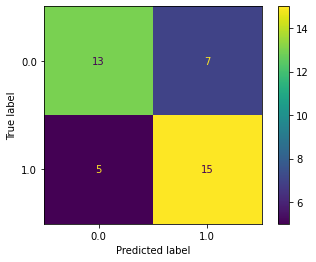

In [71]:
plot_confusion_matrix(ensemble, X_test, y_test) 

In [72]:
from sklearn.metrics import precision_recall_fscore_support,classification_report,confusion_matrix, precision_recall_curve
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.65      0.68        20
         1.0       0.68      0.75      0.71        20

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.70        40
weighted avg       0.70      0.70      0.70        40

